# Clustering

### evaluation

Since you don't currently have a target label to compare against, we'll focus on unsupervised clustering evaluation methods. Here's what we can do:

1. Silhouette Analysis:

    Calculate: Implement a function in PySpark to compute the silhouette coefficient for your clusters. Resources are available to help with this. I can provide code guidance if needed.
    Visualization: Create a box plot or a distribution plot to visualize the distribution of silhouette scores across your data points. You can use libraries like Matplotlib or Seaborn. This will help see how well-defined clusters are.

2. Elbow Method (K-Value Exploration):

    Iteration: Since you used a ParamGrid, you likely already ran K-Means with different 'k' values (the number of clusters).
    WCSS: Calculate the Within-Cluster-Sum-of-Squares (WCSS) for each 'k'. You can obtain this from the fitted KMeans model.
    Plot: Create an Elbow plot (WCSS vs. k). Look for a distinct "elbow" point suggesting a diminishing return when adding more clusters.

3. Visualization (if feasible): **Dimensionality Reduction:**  If your `scaled_production` features can be reasonably reduced to 2 or 3 dimensions using techniques like PCA or t-SNE, create a scatter plot with data points colored by their cluster assignments. This can visually show cluster separation.

### beyond evaluation

1.   Domain Knowledge:
        Do the resulting clusters make intuitive sense based on your understanding of brewing processes?
        Can you identify any distinguishing characteristics (mean, standard deviation of your original features) that separate the clusters?

2.   Utility:
        How might these clusters be used? Are there actionable insights for your brewery? Would it be helpful to track cluster memberships of batches over time to detect trends?

3.    Further Exploration:
        Other Clustering Algorithms: Consider experimenting with algorithms like Gaussian Mixture Models (if you want elliptical clusters) or DBSCAN (if you have noise or don't want to pre-specify the number of clusters).

## prep

In [1]:
import os

# Set SPARK_HOME
os.environ["SPARK_HOME"] = r"C:/Spark/spark-3.5.0-bin-hadoop3"

# Set PYTHONPATH
spark_home = os.environ.get("SPARK_HOME", "")
if spark_home:
    python_path = os.path.join(spark_home, "python")
    py4j_zip = os.path.join(spark_home, "python", "lib", "py4j-0.10.9.7-src.zip")
    os.environ["PYTHONPATH"] = f"{python_path};{py4j_zip};{os.environ.get('PYTHONPATH', '')}"

# Set PYSPARK_PYTHON
os.environ["PYSPARK_PYTHON"] = r"C:\Users\Vincenzo\AppData\Local\Programs\Python\Python38\python.exe"
print(os.environ.get('PYSPARK_PYTHON'))

# Set PATH
if spark_home:
    os.environ["PATH"] = f"{python_path};{os.path.join(spark_home, 'bin')};{os.environ.get('PATH', '')}"

C:\Users\Vincenzo\AppData\Local\Programs\Python\Python38\python.exe


In [2]:
import findspark
findspark.init()

import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import gc

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [3]:
spark = SparkSession.builder.appName("spark").config("spark.driver.memory", "24g").getOrCreate()
spark

In [4]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [5]:
df = spark.read.parquet(r"c:\Users\Vincenzo\PROJECTS\DDAM_data\brewery\brewery_data_complete_extended.parquet")
type(df)

pyspark.sql.dataframe.DataFrame

In [6]:
from pyspark.sql.functions import split, col

# Split the ratio_column into three parts based on the colon delimiter
split_col = split(col("Ingredient_Ratio"), ":")

# Create three separate columns for water, grains, and hops
df = df.withColumn("water", split_col.getItem(0).cast("double"))
df = df.withColumn("grains", split_col.getItem(1).cast("double"))
df = df.withColumn("hops", split_col.getItem(2).cast("double"))
df = df.drop("Ingredient_Ratio")

In [7]:
# Define a new column with the USD per liter ratio and brewing efficiency
df = df.withColumn("USD_per_Liter", F.col("Total_Sales") / F.col("Volume_Produced").cast("double"))
df = df.withColumn("Brewing_efficency", F.col("Brewhouse_Efficiency") / F.col("Volume_Produced").cast("double"))

In [8]:
from pyspark.sql.types import StringType

# Identify numerical and non-numerical columns
numerical_cols = [col_name for col_name, data_type in df.dtypes if data_type != 'string']
categorical_cols = [col_name for col_name, data_type in df.dtypes if data_type == 'string']

print(f'Numerical columns: {numerical_cols}')
print(f'Categorical columns: {categorical_cols}')

Numerical columns: ['Batch_ID', 'Fermentation_Time', 'Temperature', 'pH_Level', 'Gravity', 'Alcohol_Content', 'Bitterness', 'Color', 'Volume_Produced', 'Total_Sales', 'Quality_Score', 'Brewhouse_Efficiency', 'Loss_During_Brewing', 'Loss_During_Fermentation', 'Loss_During_Bottling_Kegging', 'water', 'grains', 'hops', 'USD_per_Liter', 'Brewing_efficency']
Categorical columns: ['Brew_Date', 'Beer_Style', 'SKU', 'Location']


In [9]:
# functions

from pyspark.sql.functions import when, col
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, dense_rank, when
from pyspark.sql.window import Window

def ordinal_encode_pyspark(df, input_col, output_col):
    """ Ordinal encodes a column within a PySpark DataFrame

    Args:
        df (pyspark.sql.DataFrame): The input Spark DataFrame.
        input_col (str): Name of the column to be encoded. Defaults to "Bitterness".
        output_col (str): Name for the new ordinal encoded column. Defaults to "Bitterness_ordinal".
    
    Returns:
        pyspark.sql.DataFrame: The Spark DataFrame with the ordinal encoded column.
    """

    window = Window.orderBy(input_col) 
    return df.withColumn(output_col, dense_rank().over(window)) \
             .withColumn(output_col, when(col(input_col).isNull(), 0).otherwise(col(output_col))) \
             #.drop(input_col)
             
def check_distinct_values(df, feature_col):
    """  
    Prints the distinct values of a feature in a PySpark DataFrame.

    Args:
        df (pyspark.sql.DataFrame): The PySpark DataFrame.
        feature_col (str): The name of the feature column.
    """

    distinct_values = df.select(feature_col).distinct().collect()

    print(f"Distinct values in '{feature_col}':")
    for row in distinct_values:
        print(row[feature_col]) 

    # functions

def one_hot_encode_column(df, input_col, output_col_prefix="encoded"):
    """ One-hot encodes a specified categorical column, drops intermediary columns,
        and allows for specifying the prefix of the output columns.

    Args:
        df (pyspark.sql.DataFrame): Input DataFrame.
        input_col (str): The name of the column containing categorical data.
        output_col_prefix (str): Prefix for the generated one-hot encoded column names.

    Returns:
        pyspark.sql.DataFrame: DataFrame with the one-hot encoded column(s) and 
                               intermediary columns removed.
    """

    indexer = StringIndexer(inputCol=input_col, outputCol=input_col + "_index")
    encoder = OneHotEncoder(inputCol=input_col + "_index", outputCol=output_col_prefix + input_col + "features")
    assembler = VectorAssembler(inputCols=[input_col + "_index"], outputCol="features") 

    pipeline = Pipeline(stages=[indexer, assembler, encoder])
    transformed_df = pipeline.fit(df).transform(df)

    # Drop unnecessary columns
    drop_cols = [input_col + "_index", "features"]
    return transformed_df.drop(*drop_cols)  # Dynamic column dropping

def discretize_and_encode(df, input_col="fermentation_time"):
    """ Discretizes a feature into bins, one-hot encodes the bins, and preserves the original column

    Args:
        df (pyspark.sql.DataFrame): Input DataFrame
        input_col (str): Name of the column to be discretized and encoded

    Returns:
        pyspark.sql.DataFrame:  DataFrame with new discretization and encoded columns
    """

    df = df.withColumn(input_col + "_bin", 
                       when((col(input_col) >= 10) & (col(input_col) <= 13), "Short")
                       .when((col(input_col) >= 14) & (col(input_col) <= 16), "Medium")
                       .otherwise("Long"))
    
    return one_hot_encode_column(df, input_col=input_col + "_bin") 

In [10]:
#discretize and encode is hardcoded for fermentation time (!!)

df = discretize_and_encode(df)
df.select("encodedfermentation_time_binfeatures").show(5)

+------------------------------------+
|encodedfermentation_time_binfeatures|
+------------------------------------+
|                           (2,[],[])|
|                       (2,[0],[1.0])|
|                       (2,[0],[1.0])|
|                       (2,[1],[1.0])|
|                       (2,[1],[1.0])|
+------------------------------------+
only showing top 5 rows



In [11]:
df = one_hot_encode_column(df, "Beer_Style")
df.select("encodedBeer_Stylefeatures").show(5)

+-------------------------+
|encodedBeer_Stylefeatures|
+-------------------------+
|                (7,[],[])|
|            (7,[2],[1.0])|
|                (7,[],[])|
|            (7,[0],[1.0])|
|            (7,[3],[1.0])|
+-------------------------+
only showing top 5 rows



In [12]:
df = one_hot_encode_column(df, "SKU")
df.select("encodedSKUfeatures").show(5)

+------------------+
|encodedSKUfeatures|
+------------------+
|         (3,[],[])|
|         (3,[],[])|
|         (3,[],[])|
|         (3,[],[])|
|     (3,[2],[1.0])|
+------------------+
only showing top 5 rows



In [13]:
df = one_hot_encode_column(df, "Location")
df.select("encodedLocationfeatures").show(5)

+-----------------------+
|encodedLocationfeatures|
+-----------------------+
|              (9,[],[])|
|              (9,[],[])|
|          (9,[7],[1.0])|
|          (9,[4],[1.0])|
|          (9,[3],[1.0])|
+-----------------------+
only showing top 5 rows



### only ale - df

In [14]:
from pyspark.sql.functions import count

# 1. Get unique beer styles
beer_styles = df.select("Beer_Style").distinct().collect()
print(beer_styles)

# 2. Count data points per style
df.groupBy("Beer_Style") \
  .agg(count("*").alias("count")) \
  .orderBy("count", ascending=False) \
  .show() 

[Row(Beer_Style='Porter'), Row(Beer_Style='Sour'), Row(Beer_Style='Lager'), Row(Beer_Style='Wheat Beer'), Row(Beer_Style='Pilsner'), Row(Beer_Style='Ale'), Row(Beer_Style='Stout'), Row(Beer_Style='IPA')]
+----------+-------+
|Beer_Style|  count|
+----------+-------+
|       Ale|1251002|
|    Porter|1250773|
|      Sour|1250307|
|     Stout|1250296|
|       IPA|1249603|
|     Lager|1249570|
|   Pilsner|1249426|
|Wheat Beer|1249023|
+----------+-------+



In [15]:
ale_df = df.filter(df.Beer_Style == "Ale")
ale_df.show(5)

+--------+-------------------+----------+-----+------------+-----------------+------------------+-----------------+------------------+-----------------+----------+-----+---------------+------------------+-----------------+--------------------+-------------------+------------------------+----------------------------+-----+------+----+------------------+--------------------+---------------------+------------------------------------+-------------------------+------------------+-----------------------+
|Batch_ID|          Brew_Date|Beer_Style|  SKU|    Location|Fermentation_Time|       Temperature|         pH_Level|           Gravity|  Alcohol_Content|Bitterness|Color|Volume_Produced|       Total_Sales|    Quality_Score|Brewhouse_Efficiency|Loss_During_Brewing|Loss_During_Fermentation|Loss_During_Bottling_Kegging|water|grains|hops|     USD_per_Liter|   Brewing_efficency|fermentation_time_bin|encodedfermentation_time_binfeatures|encodedBeer_Stylefeatures|encodedSKUfeatures|encodedLocationfe

### drop unnecessary

In [16]:
ale_df = ale_df.drop("Location", "SKU", "Beer_Style", "fermentation_time_bin")

In [17]:
df = df.drop("Location", "SKU", "Beer_Style", "fermentation_time_bin")

### sampling

In [18]:
sample = df.sample(0.1, seed=42) # 10% of the data

In [19]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
from pyspark.ml.evaluation import ClusteringEvaluator
import pyspark.sql.functions as F
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
import pandas as pd 
import pylab as pl
import numpy as np

## KMEANS

- Production Factors: Fermentation Time, Temperature, pH_Level, Ingredient_Ratio
- Product Characteristics: Beer_Style, Alcohol_Content, Bitterness, Color.
- natural clusters

### production

- Silhouette Score: 
- Best number of clusters:

#### prep

In [ ]:
# Features
production_features = ["Fermentation_Time", "Temperature", "pH_Level", "Gravity",  "water", "grains", "hops"] 
assembler = VectorAssembler(inputCols=production_features, outputCol="features_production")
scaler = StandardScaler(inputCol="features_production", outputCol="features")

# Algos
kmeans = KMeans().setSeed(1).setFeaturesCol("features").setPredictionCol("prediction")

# Pipeline Stages
pipeline = Pipeline(stages=[assembler, scaler, kmeans])

# Evaluator
evaluator = ClusteringEvaluator()
evaluator.setMetricName("silhouette")
# evaluator.setPredictionCol("other_prediction_col")
# evaluator.setFeaturesCol("other_features_col")

#### training cost elbow method

In [ ]:
# List of single 'k' values you want to test
k_values = [2,3,4,5,6,7,8,10,12,14,16,18,20,22,24,26,28,30] 

# Initialize cost storage
costs = np.zeros(len(k_values))

# Loop through k_values (and calculate costs)
for i, k in enumerate(k_values): 
    kmeans = pipeline.setStages([*pipeline.getStages()[:-1], KMeans().setK(k)])
    model = pipeline.fit(df) 
    costs[i] = model.stages[-1].summary.trainingCost 

# Plot the cost (Elbow Curve)
df_cost = pd.DataFrame(costs, index=k_values) # Adjusted for k_values
df_cost.columns = ["cost"]
df_cost.insert(0, 'cluster', k_values)

pl.plot(df_cost.index, df_cost.cost) # Use index for x-axis
pl.xlabel('Number of Clusters')
pl.xticks(k_values)
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

#### cross validation

In [ ]:
# Hyperparameter Tuning
paramGrid = ParamGridBuilder() \
    .addGrid(kmeans.k, [2,3,4,5,6,8,10,12,14]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [ ]:
# Fit and Evaluate
Model_production = crossval.fit(df) 
predictions_production = Model_production.transform(df)

In [ ]:
best_model = Model_production.bestModel 
best_k = best_model.stages[-1].getK()
print(f"Best number of clusters: {best_k}")

#### no cross validation

In [ ]:
# Fit and Evaluate
kmeans.setK(12)

Model_production = pipeline.fit(df) 
predictions_production = Model_production.transform(df)

In [ ]:
predictions_production = predictions_production.drop("features_production")
predictions_production.show(5)

#### Silhouette analysis

In [ ]:
silhouette = evaluator.evaluate(predictions_production)
print(f"Silhouette Score: {silhouette:.3f}")

In [ ]:
predictions_production.groupBy("prediction") \
  .agg(count("*").alias("count")) \
  .orderBy("count", ascending=False) \
  .show()

#### PCA

In [ ]:
from pyspark.ml.feature import PCA 

pca = PCA(k=2, inputCol="features", outputCol="pca_features")  # k=2 for 2D visualization
pca_model = pca.fit(predictions_production)

df_transformed = pca_model.transform(predictions_production)

In [ ]:
import pandas as pd

results = df_transformed.select("pca_features", "prediction").toPandas()
pca_features = results["pca_features"].tolist()
predictions = results["prediction"].tolist()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 

colors = ['#e6194b', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1']

# Convert lists to NumPy arrays for efficient plotting
x_coords = np.array([feature[0] for feature in pca_features])
y_coords = np.array([feature[1] for feature in pca_features])
colors_array = np.array(colors)[predictions]  # Map colors to predictions

# Plot all points at once
plt.scatter(x_coords, y_coords, c=colors_array)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Visualization of Clusters using PCA")
plt.show()

In [ ]:
component_matrix = pca_model.explainedVariance.toArray()  # Weights as an array

print("Component 1 Weights:", component_matrix[0]) 
print("Component 2 Weights:", component_matrix[1])

#### PCA 3d

In [ ]:
from pyspark.ml.feature import PCA 

pca = PCA(k=3, inputCol="features", outputCol="pca_features")  # k=3 for 3D 
pca_model = pca.fit(predictions_production)
df_transformed = pca_model.transform(predictions_production)

In [ ]:
import pandas as pd

results = df_transformed.select("pca_features", "prediction").toPandas()
pca_features = results["pca_features"].tolist()
predictions = results["prediction"].tolist()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting

import matplotlib.pyplot as plt
import numpy as np 

colors = ['#e6194b', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1']

# Convert lists to NumPy arrays for efficient plotting
x_coords = np.array([feature[0] for feature in pca_features])
y_coords = np.array([feature[1] for feature in pca_features])
z_coords = np.array([feature[2] for feature in pca_features])
colors_array = np.array(colors)[predictions]  # Map colors to predictions

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

# 3D scatter plot
ax.scatter(x_coords, y_coords, z_coords, c=colors_array)

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3") 
plt.title("Visualization of Clusters using PCA (3D)")
plt.show()

In [ ]:
component_matrix = pca_model.explainedVariance.toArray()  # Weights as an array

print("Component 1 Weights:", component_matrix[0]) 
print("Component 2 Weights:", component_matrix[1])
print("Component 3 Weights:", component_matrix[2])

### product

- Silhouette Score: 
- number of clusters:

#### prep

In [20]:
#Features
product_features = ["Alcohol_Content", "Bitterness", "Color"]
assembler = VectorAssembler(inputCols=product_features, outputCol="features_product")
scaler = StandardScaler(inputCol="features_product", outputCol="features")

# Algos
kmeans = KMeans().setSeed(1).setFeaturesCol("features").setPredictionCol("prediction")

# Pipeline Stages
pipeline = Pipeline(stages=[assembler, scaler, kmeans])

# Evaluator
evaluator = ClusteringEvaluator()
evaluator.setMetricName("silhouette")

ClusteringEvaluator_1e126d50adf2

#### training cost - elbow method

In [ ]:
# List of single 'k' values you want to test
k_values = [2,3,4,5,6,7,8,10,12,14,16,18,20,22,24,26,28,30] 

# Initialize cost storage
costs = np.zeros(len(k_values))

# Loop through k_values (and calculate costs)
for i, k in enumerate(k_values): 
    kmeans = pipeline.setStages([*pipeline.getStages()[:-1], KMeans().setK(k)])
    model = pipeline.fit(df) 
    costs[i] = model.stages[-1].summary.trainingCost 

# Plot the cost (Elbow Curve)
df_cost = pd.DataFrame(costs, index=k_values) # Adjusted for k_values
df_cost.columns = ["cost"]
df_cost.insert(0, 'cluster', k_values)

pl.plot(df_cost.index, df_cost.cost) # Use index for x-axis
pl.xlabel('Number of Clusters')
pl.xticks(k_values)
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

#### cross validation

In [ ]:
# Hyperparameter Tuning
paramGrid = ParamGridBuilder() \
    .addGrid(kmeans.k, [8,10,12,14,16,18,20]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [ ]:
# Fit and Evaluate
Model_product = crossval.fit(df)
predictions_product = Model_product.transform(df)

In [ ]:
best_model = Model_product.bestModel 
best_k = best_model.stages[-1].getK()
print(f"Best number of clusters: {best_k}")

#### no cross validation

In [21]:
# Fit and Evaluate
kmeans = kmeans.setK(8).setDistanceMeasure("cosine")

Model_product = pipeline.fit(sample)
predictions_product = Model_product.transform(sample)

In [22]:
predictions_product = predictions_product.drop("features_product")

#### silhouette analysis

In [23]:
silhouette = evaluator.evaluate(predictions_product)
print(f"Silhouette Score: {silhouette:.3f}")

Silhouette Score: 0.216


In [24]:
predictions_product.groupBy("prediction") \
  .agg(count("*").alias("count")) \
  .orderBy("count", ascending=False) \
  .show()

+----------+------+
|prediction| count|
+----------+------+
|         0|145016|
|         7|139906|
|         5|134114|
|         2|130326|
|         3|127807|
|         4|114713|
|         6|107602|
|         1|102107|
+----------+------+



#### PCA 2d

In [25]:
from pyspark.ml.feature import PCA 

pca = PCA(k=2, inputCol="features", outputCol="pca_features")  # k=2 for 2D visualization
pca_model = pca.fit(predictions_product)
df_transformed = pca_model.transform(predictions_product)

In [26]:
import pandas as pd

results = df_transformed.select("pca_features", "prediction").toPandas()
pca_features = results["pca_features"].tolist()
predictions = results["prediction"].tolist()

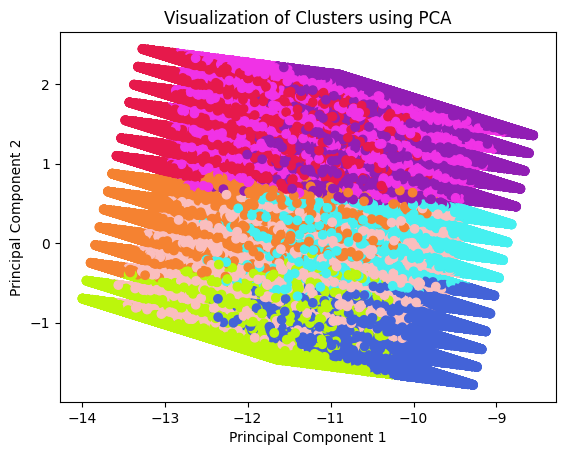

In [27]:
import matplotlib.pyplot as plt
import numpy as np 

colors = ['#e6194b', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1']

# Convert lists to NumPy arrays for efficient plotting
x_coords = np.array([feature[0] for feature in pca_features])
y_coords = np.array([feature[1] for feature in pca_features])
colors_array = np.array(colors)[predictions]  # Map colors to predictions

# Plot all points at once
plt.scatter(x_coords, y_coords, c=colors_array)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Visualization of Clusters using PCA")
plt.show()

In [28]:
component_matrix = pca_model.explainedVariance.toArray()  # Weights as an array

print("Component 1 Weights:", component_matrix[0]) 
print("Component 2 Weights:", component_matrix[1])

Component 1 Weights: 0.3338774420732675
Component 2 Weights: 0.33330892043935306


#### PCA 3d

In [29]:
from pyspark.ml.feature import PCA 

pca = PCA(k=3, inputCol="features", outputCol="pca_features")  # k=3 for 3D 
pca_model = pca.fit(predictions_product)
df_transformed = pca_model.transform(predictions_product)

In [30]:
import pandas as pd

results = df_transformed.select("pca_features", "prediction").toPandas()
pca_features = results["pca_features"].tolist()
predictions = results["prediction"].tolist()

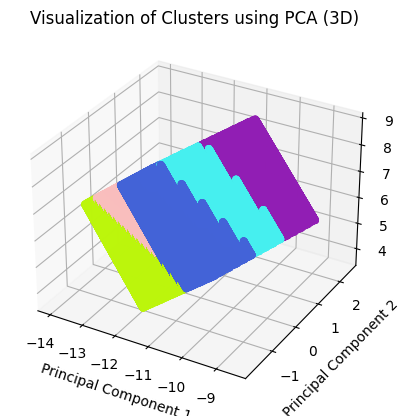

In [31]:
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting

import matplotlib.pyplot as plt
import numpy as np 

colors = ['#e6194b', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1']

# Convert lists to NumPy arrays for efficient plotting
x_coords = np.array([feature[0] for feature in pca_features])
y_coords = np.array([feature[1] for feature in pca_features])
z_coords = np.array([feature[2] for feature in pca_features])
colors_array = np.array(colors)[predictions]  # Map colors to predictions

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

# 3D scatter plot
ax.scatter(x_coords, y_coords, z_coords, c=colors_array)

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3") 
plt.title("Visualization of Clusters using PCA (3D)")
plt.show()

In [32]:
component_matrix = pca_model.explainedVariance.toArray()  # Weights as an array

print("Component 1 Weights:", component_matrix[0]) 
print("Component 2 Weights:", component_matrix[1])
print("Component 3 Weights:", component_matrix[2])

Component 1 Weights: 0.3338774420732675
Component 2 Weights: 0.33330892043935295
Component 3 Weights: 0.3328136374873795


### natural clusters

- Silhouette Score: 
- Best number of clusters:

#### prep

In [20]:
#Features
columns = df.columns
irrelevant_features = ["Batch_ID", "Brew_Date", "USD_per_Liter", "Brewing_efficency", "Total_Sales", "fermentation_time_bin"] 
all_features = [col for col in columns if col not in irrelevant_features]

assembler = VectorAssembler(inputCols=all_features, outputCol="features_all")
scaler = StandardScaler(inputCol="features_all", outputCol="features")

# Algos
kmeans = KMeans().setSeed(1).setFeaturesCol("features").setPredictionCol("prediction")

# Pipeline Stages
pipeline = Pipeline(stages=[assembler, scaler, kmeans])

# Evaluator
evaluator = ClusteringEvaluator()
evaluator.setMetricName("silhouette")

ClusteringEvaluator_f3af2ddbc307

#### Training cost - elbow method

In [ ]:
# List of single 'k' values you want to test
k_values = [2,3,4,5,6,7,8,10,12,14,16,18,20,22,24,26,28,30] 

# Initialize cost storage
costs = np.zeros(len(k_values))

# Loop through k_values (and calculate costs)
for i, k in enumerate(k_values): 
    kmeans = pipeline.setStages([*pipeline.getStages()[:-1], KMeans().setK(k)])
    model = pipeline.fit(ale_df)
    costs[i] = model.stages[-1].summary.trainingCost 

# Plot the cost (Elbow Curve)
df_cost = pd.DataFrame(costs, index=k_values) # Adjusted for k_values
df_cost.columns = ["cost"]
df_cost.insert(0, 'cluster', k_values)

pl.plot(df_cost.index, df_cost.cost) # Use index for x-axis
pl.xlabel('Number of Clusters')
pl.xticks(k_values)
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

#### cross validation

In [ ]:
# Hyperparameter Tuning
paramGrid = ParamGridBuilder() \
    .addGrid(kmeans.k, [10,12,14,16]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [ ]:
# Fit and Evaluate
Model_all = crossval.fit(df) 
predictions_all = Model_all.transform(df)

In [ ]:
best_model = Model_all.bestModel 
best_k = best_model.stages[-1].getK()
print(f"Best number of clusters: {best_k}")

#### no cross validation

In [22]:
# Fit and Evaluate 
kmeans = kmeans.setK(12)

Model_all = pipeline.fit(sample)
predictions_all = Model_all.transform(sample)

In [23]:
predictions_all = predictions_all.drop("features_all")

#### Silhouette analysis

In [24]:
silhouette = evaluator.evaluate(predictions_all)
print(f"Silhouette Score: {silhouette:.3f}")

Silhouette Score: 0.119


In [ ]:
predictions_all.groupBy("prediction") \
  .agg(count("*").alias("count")) \
  .orderBy("count", ascending=False) \
  .show()

#### PCA

In [ ]:
from pyspark.ml.feature import PCA 

pca = PCA(k=2, inputCol="features", outputCol="pca_features")  # k=2 for 2D visualization
pca_model = pca.fit(predictions_all)

df_transformed = pca_model.transform(predictions_all)

In [ ]:
import pandas as pd

results = df_transformed.select("pca_features", "prediction").toPandas()
pca_features = results["pca_features"].tolist()
predictions = results["prediction"].tolist()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 

colors = ['#e6194b', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1']

# Convert lists to NumPy arrays for efficient plotting
x_coords = np.array([feature[0] for feature in pca_features])
y_coords = np.array([feature[1] for feature in pca_features])
colors_array = np.array(colors)[predictions]  # Map colors to predictions

# Plot all points at once
plt.scatter(x_coords, y_coords, c=colors_array)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Visualization of Clusters using PCA")
plt.show()


In [ ]:
component_matrix = pca_model.explainedVariance.toArray()  # Weights as an array

print("Component 1 Weights:", component_matrix[0]) 
print("Component 2 Weights:", component_matrix[1])

#### PCA 3d

In [ ]:
from pyspark.ml.feature import PCA 

pca = PCA(k=3, inputCol="features", outputCol="pca_features")  # k=3 for 3D 
pca_model = pca.fit(predictions_all)
df_transformed = pca_model.transform(predictions_all)

In [ ]:
import pandas as pd

results = df_transformed.select("pca_features", "prediction").toPandas()
pca_features = results["pca_features"].tolist()
predictions = results["prediction"].tolist()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting

import matplotlib.pyplot as plt
import numpy as np 

colors = ['#e6194b', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1']

# Convert lists to NumPy arrays for efficient plotting
x_coords = np.array([feature[0] for feature in pca_features])
y_coords = np.array([feature[1] for feature in pca_features])
z_coords = np.array([feature[2] for feature in pca_features])
colors_array = np.array(colors)[predictions]  # Map colors to predictions

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

# 3D scatter plot
ax.scatter(x_coords, y_coords, z_coords, c=colors_array)

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3") 
plt.title("Visualization of Clusters using PCA (3D)")
plt.show()

In [ ]:
component_matrix = pca_model.explainedVariance.toArray()  # Weights as an array

print("Component 1 Weights:", component_matrix[0]) 
print("Component 2 Weights:", component_matrix[1])
print("Component 3 Weights:", component_matrix[2])

## Bisecting KMEANS

- Production Factors: Fermentation Time, Temperature, pH_Level, Ingredient_Ratio
- Product Characteristics: Beer_Style, Alcohol_Content, Bitterness, Color.
- natural clusters

### production

#### prep

In [ ]:
# Features
production_features = ["Fermentation_Time", "Temperature", "pH_Level", "Gravity",  "water", "grains", "hops"] 
assembler = VectorAssembler(inputCols=production_features, outputCol="features_production")
scaler = StandardScaler(inputCol="features_production", outputCol="features")

# Algos
b_kmeans = BisectingKMeans().setSeed(1).setFeaturesCol("features").setPredictionCol("prediction")

# Pipeline Stages
pipeline = Pipeline(stages=[assembler, scaler, b_kmeans])

# Evaluator
evaluator = ClusteringEvaluator()
evaluator.setMetricName("silhouette")

#### cross validation

In [ ]:
# Hyperparameter Tuning
k_values = [2,3,4,5,6,7,8,10]
max_iter_values = [5, 7, 10]
min_divisible_cluster_size_values = [1000, 2500,5000, 10000, 15000] 

paramGrid = ParamGridBuilder() \
            .addGrid(b_kmeans.k, k_values) \
            .addGrid(b_kmeans.maxIter, max_iter_values) \
            .addGrid(b_kmeans.minDivisibleClusterSize, min_divisible_cluster_size_values) \
            .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [ ]:
# Fit and Evaluate
Model_production = crossval.fit(df)
predictions_production = Model_production.transform(df)

In [ ]:
best_model = Model_production.bestModel 
best_k = best_model.stages[-1].getK()
print(f"Best number of clusters: {best_k}")

#### no cross validation

In [ ]:
# Fit and Evaluate 
b_kmeans = b_kmeans #set the best parameters

Model_production = pipeline.fit(df)
predictions_production = Model_production.transform(df)

In [ ]:
predictions_production = predictions_production.drop("features_product")

#### Silhouette analysis

In [ ]:
silhouette = evaluator.evaluate(predictions_production)
print("Silhouette Score:", silhouette)

In [ ]:
predictions_production.groupBy("prediction") \
  .agg(count("*").alias("count")) \
  .orderBy("count", ascending=False) \
  .show()

#### PCA

In [ ]:
from pyspark.ml.feature import PCA 

pca = PCA(k=2, inputCol="features", outputCol="pca_features")  # k=2 for 2D visualization
pca_model = pca.fit(predictions_production)

df_transformed = pca_model.transform(predictions_production)

In [ ]:
import pandas as pd

results = df_transformed.select("pca_features", "prediction").toPandas()
pca_features = results["pca_features"].tolist()
predictions = results["prediction"].tolist()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 

colors = ['#e6194b', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1']

# Convert lists to NumPy arrays for efficient plotting
x_coords = np.array([feature[0] for feature in pca_features])
y_coords = np.array([feature[1] for feature in pca_features])
colors_array = np.array(colors)[predictions]  # Map colors to predictions

# Plot all points at once
plt.scatter(x_coords, y_coords, c=colors_array)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Visualization of Clusters using PCA")
plt.show()


In [ ]:
component_matrix = pca_model.explainedVariance.toArray()  # Weights as an array

print("Component 1 Weights:", component_matrix[0]) 
print("Component 2 Weights:", component_matrix[1])

#### PCA 3d

In [ ]:
from pyspark.ml.feature import PCA 

pca = PCA(k=3, inputCol="features", outputCol="pca_features")  # k=3 for 3D 
pca_model = pca.fit(predictions_production)
df_transformed = pca_model.transform(predictions_production)

In [ ]:
import pandas as pd

results = df_transformed.select("pca_features", "prediction").toPandas()
pca_features = results["pca_features"].tolist()
predictions = results["prediction"].tolist()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting

import matplotlib.pyplot as plt
import numpy as np 

colors = ['#e6194b', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1']

# Convert lists to NumPy arrays for efficient plotting
x_coords = np.array([feature[0] for feature in pca_features])
y_coords = np.array([feature[1] for feature in pca_features])
z_coords = np.array([feature[2] for feature in pca_features])
colors_array = np.array(colors)[predictions]  # Map colors to predictions

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

# 3D scatter plot
ax.scatter(x_coords, y_coords, z_coords, c=colors_array)

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3") 
plt.title("Visualization of Clusters using PCA (3D)")
plt.show()

In [ ]:
component_matrix = pca_model.explainedVariance.toArray()  # Weights as an array

print("Component 1 Weights:", component_matrix[0]) 
print("Component 2 Weights:", component_matrix[1])
print("Component 3 Weights:", component_matrix[2])

### product

#### prep

In [ ]:
#Features
product_features = ["Alcohol_Content", "Bitterness", "Color"]
assembler = VectorAssembler(inputCols=product_features, outputCol="features_product")
scaler = StandardScaler(inputCol="features_product", outputCol="features")

# Algos
b_kmeans = BisectingKMeans().setSeed(1).setFeaturesCol("features").setPredictionCol("prediction")

# Pipeline Stages
pipeline = Pipeline(stages=[assembler, scaler, b_kmeans])

# Evaluator
evaluator = ClusteringEvaluator()
evaluator.setMetricName("silhouette")

#### cross-val

In [ ]:
# Hyperparameter Tuning
k_values = [2,3,4,5,6,7,8,10,12,14,16,18,20]
max_iter_values = [5, 7, 10]
min_divisible_cluster_size_values = [1000, 2500,5000, 10000, 15000] 

paramGrid = ParamGridBuilder() \
            .addGrid(b_kmeans.k, k_values) \
            .addGrid(b_kmeans.maxIter, max_iter_values) \
            .addGrid(b_kmeans.minDivisibleClusterSize, min_divisible_cluster_size_values) \
            .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [ ]:
# Fit and Evaluate
Model_product = crossval.fit(df)
predictions_product = Model_product.transform(df)

In [ ]:
best_model = Model_product.bestModel 
best_k = best_model.stages[-1].getK()
print(f"Best number of clusters: {best_k}")

#### no cross validation

In [ ]:
# Fit and Evaluate 
b_kmeans = b_kmeans #set the best parameters

Model_product = pipeline.fit(df)
predictions_product = Model_product.transform(df)

In [ ]:
predictions_product = predictions_product.drop("features_product")

#### silhouette analysis

In [ ]:
silhouette = evaluator.evaluate(predictions_product)
print(f"Silhouette Score: {silhouette:.3f}")

In [ ]:
predictions_product.groupBy("prediction") \
  .agg(count("*").alias("count")) \
  .orderBy("count", ascending=False) \
  .show()

#### PCA

In [ ]:
from pyspark.ml.feature import PCA 

pca = PCA(k=2, inputCol="features", outputCol="pca_features")  # k=2 for 2D visualization
pca_model = pca.fit(predictions_product)

df_transformed = pca_model.transform(predictions_product)

In [ ]:
import pandas as pd

results = df_transformed.select("pca_features", "prediction").toPandas()
pca_features = results["pca_features"].tolist()
predictions = results["prediction"].tolist()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 

colors = ['#e6194b', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1']

# Convert lists to NumPy arrays for efficient plotting
x_coords = np.array([feature[0] for feature in pca_features])
y_coords = np.array([feature[1] for feature in pca_features])
colors_array = np.array(colors)[predictions]  # Map colors to predictions

# Plot all points at once
plt.scatter(x_coords, y_coords, c=colors_array)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Visualization of Clusters using PCA")
plt.show()


In [ ]:
component_matrix = pca_model.explainedVariance.toArray()  # Weights as an array

print("Component 1 Weights:", component_matrix[0]) 
print("Component 2 Weights:", component_matrix[1])

#### PCA 3d

In [ ]:
from pyspark.ml.feature import PCA 

pca = PCA(k=3, inputCol="features", outputCol="pca_features")  # k=3 for 3D 
pca_model = pca.fit(predictions_product)
df_transformed = pca_model.transform(predictions_product)

In [ ]:
import pandas as pd

results = df_transformed.select("pca_features", "prediction").toPandas()
pca_features = results["pca_features"].tolist()
predictions = results["prediction"].tolist()

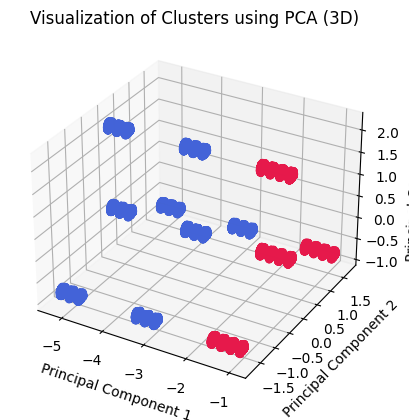

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting

import matplotlib.pyplot as plt
import numpy as np 

colors = ['#e6194b', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1']

# Convert lists to NumPy arrays for efficient plotting
x_coords = np.array([feature[0] for feature in pca_features])
y_coords = np.array([feature[1] for feature in pca_features])
z_coords = np.array([feature[2] for feature in pca_features])
colors_array = np.array(colors)[predictions]  # Map colors to predictions

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

# 3D scatter plot
ax.scatter(x_coords, y_coords, z_coords, c=colors_array)

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3") 
plt.title("Visualization of Clusters using PCA (3D)")
plt.show()

In [ ]:
component_matrix = pca_model.explainedVariance.toArray()  # Weights as an array

print("Component 1 Weights:", component_matrix[0]) 
print("Component 2 Weights:", component_matrix[1])
print("Component 3 Weights:", component_matrix[2])

Component 1 Weights: 0.06849039621271737
Component 2 Weights: 0.037078196050297364
Component 3 Weights: 0.03701349758497346


### natural clusters

#### prep

In [20]:
#Features
columns = sample.columns
irrelevant_features = ["Batch_ID", "Brew_Date", "USD_per_Liter", "Brewing_efficency", "Total_Sales", "fermentation_time_bin"] 
all_features = [col for col in columns if col not in irrelevant_features]

# Assembler and Scaler
assembler = VectorAssembler(inputCols=all_features, outputCol="features_all")
scaler = StandardScaler(inputCol="features_all", outputCol="features")

# Algo
b_kmeans = BisectingKMeans().setSeed(1).setFeaturesCol("features").setPredictionCol("prediction")

# Pipeline Stages
pipeline = Pipeline(stages=[assembler, scaler, b_kmeans])

# Evaluator
evaluator = ClusteringEvaluator()
evaluator.setMetricName("silhouette")

ClusteringEvaluator_d188b1476ea1

#### cross-val

In [21]:
# Hyperparameter Tuning
k_values = [2,3,4,5,6,7,8,10]
max_iter_values = [5, 7, 10, 15,20]
# min_divisible_cluster_size_values = [1000, 2500, 5000, 10000, 15000]

paramGrid = ParamGridBuilder() \
            .addGrid(b_kmeans.k, k_values) \
            .addGrid(b_kmeans.maxIter, max_iter_values).build()
            # .addGrid(b_kmeans.minDivisibleClusterSize, min_divisible_cluster_size_values) \
            # .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [22]:
# Fit and Evaluate
Model_all = crossval.fit(sample)
predictions_all = Model_all.transform(sample)

In [23]:
best_model = Model_all.bestModel 
best_k = best_model.stages[-1].getK()
best_maxiter = best_model.stages[-1].getMaxIter()
best_minDivisibleClusterSize = best_model.stages[-1].getMinDivisibleClusterSize()

print(f"Best number of clusters: {best_k}")
print(f"Best maxIter: {best_maxiter}")
print(f"Best minDivisibleClusterSize: {best_minDivisibleClusterSize}")

Best number of clusters: 2
Best maxIter: 7
Best minDivisibleClusterSize: 1.0


#### no cross validation

In [ ]:
# Fit and Evaluate 
b_kmeans = b_kmeans #set the best parameters

Model_all = pipeline.fit(sample)
predictions_all = Model_all.transform(sample)

In [24]:
predictions_all = predictions_all.drop("features_all")

#### silhouette analysis

In [25]:
silhouette = evaluator.evaluate(predictions_all)
print(f"Silhouette Score: {silhouette:.3f}")

Silhouette Score: 0.105


In [26]:
predictions_all.groupBy("prediction") \
  .agg(count("*").alias("count")) \
  .orderBy("count", ascending=False) \
  .show()

+----------+------+
|prediction| count|
+----------+------+
|         1|600802|
|         0|400789|
+----------+------+



#### PCA

In [27]:
from pyspark.ml.feature import PCA 

pca = PCA(k=2, inputCol="features", outputCol="pca_features")  # k=2 for 2D visualization
pca_model = pca.fit(predictions_all)

df_transformed = pca_model.transform(predictions_all)

In [28]:
import pandas as pd

results = df_transformed.select("pca_features", "prediction").toPandas()
pca_features = results["pca_features"].tolist()
predictions = results["prediction"].tolist()

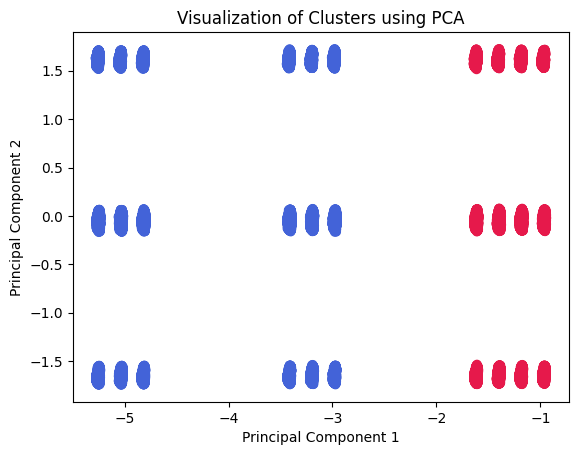

In [29]:
import matplotlib.pyplot as plt
import numpy as np 

colors = ['#e6194b', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1']

# Convert lists to NumPy arrays for efficient plotting
x_coords = np.array([feature[0] for feature in pca_features])
y_coords = np.array([feature[1] for feature in pca_features])
colors_array = np.array(colors)[predictions]  # Map colors to predictions

# Plot all points at once
plt.scatter(x_coords, y_coords, c=colors_array)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Visualization of Clusters using PCA")
plt.show()


In [30]:
component_matrix = pca_model.explainedVariance.toArray()  # Weights as an array

print("Component 1 Weights:", component_matrix[0]) 
print("Component 2 Weights:", component_matrix[1])

Component 1 Weights: 0.06849039621271737
Component 2 Weights: 0.03707819605029739


#### PCA 3d

In [31]:
from pyspark.ml.feature import PCA 

pca = PCA(k=3, inputCol="features", outputCol="pca_features")  # k=3 for 3D 
pca_model = pca.fit(predictions_all)
df_transformed = pca_model.transform(predictions_all)

In [32]:
import pandas as pd

results = df_transformed.select("pca_features", "prediction").toPandas()
pca_features = results["pca_features"].tolist()
predictions = results["prediction"].tolist()

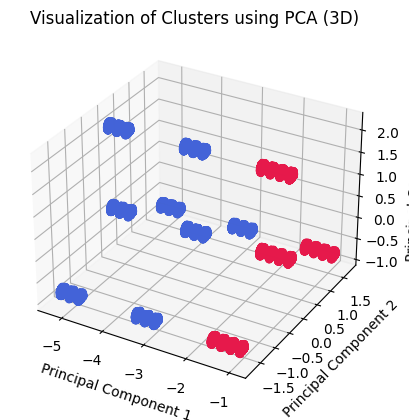

In [33]:
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting

import matplotlib.pyplot as plt
import numpy as np 

colors = ['#e6194b', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1']

# Convert lists to NumPy arrays for efficient plotting
x_coords = np.array([feature[0] for feature in pca_features])
y_coords = np.array([feature[1] for feature in pca_features])
z_coords = np.array([feature[2] for feature in pca_features])
colors_array = np.array(colors)[predictions]  # Map colors to predictions

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

# 3D scatter plot
ax.scatter(x_coords, y_coords, z_coords, c=colors_array)

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3") 
plt.title("Visualization of Clusters using PCA (3D)")
plt.show()

In [34]:
component_matrix = pca_model.explainedVariance.toArray()  # Weights as an array

print("Component 1 Weights:", component_matrix[0]) 
print("Component 2 Weights:", component_matrix[1])
print("Component 3 Weights:", component_matrix[2])

Component 1 Weights: 0.06849039621271737
Component 2 Weights: 0.037078196050297364
Component 3 Weights: 0.03701349758497346


## GMM

##### Training log-likelihood - elbow-ish method

In [ ]:
import pyspark.sql.functions as F
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
import pandas as pd 
import pylab as pl

# Calculate scores and plot (Modified for GMM)
scores = {}  # Use a dictionary to store scores

for k in range(8, 41, 2):
    gmm = GaussianMixture().setK(k).setSeed(1).setFeaturesCol('features')
    pipeline = Pipeline(stages=[assembler, scaler, gmm])  # Pipeline with GMM
    model = pipeline.fit(df) 

    # GaussianMixture has no 'trainingCost' attribute, using log-likelihood instead
    scores[k] = model.summary.logLikelihood  

# Plot the scores
df_scores = pd.DataFrame.from_dict(scores, orient='index', columns=['log_likelihood']) 
new_col = [8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40]
df_scores.index = new_col

pl.plot(df_scores.index, df_scores.log_likelihood)
pl.xlabel('Number of Clusters')
pl.ylabel('Log Likelihood')
pl.title('Elbow Curve')
pl.show()


## DBSCAN

In [20]:
import dbscan
from sklearn.datasets import make_blobs
from pyspark.sql import types as T
from scipy.spatial import distance

In [21]:
#Features
columns = df.columns
irrelevant_features = ["Batch_ID", "Brew_Date", "USD_per_Liter", "Brewing_efficency", "Total_Sales", "fermentation_time_bin"] 
all_features = [col for col in columns if col not in irrelevant_features]

assembler = VectorAssembler(inputCols=all_features, outputCol="features_all")
scaler = StandardScaler(inputCol="features_all", outputCol="features")

# Pipeline Stages
pipeline = Pipeline(stages=[assembler, scaler])

# Evaluator
evaluator = ClusteringEvaluator()
evaluator.setMetricName("silhouette")

ClusteringEvaluator_d91d3e4e067a

In [22]:
scaled_df = pipeline.fit(sample).transform(sample)

In [23]:
scaled_df = scaled_df.select("features", "Batch_ID")

In [24]:
scaled_df.show()

+--------------------+--------+
|            features|Batch_ID|
+--------------------+--------+
|(37,[0,1,2,3,4,5,...| 8843420|
|(37,[0,1,2,3,4,5,...| 1816588|
|(37,[0,1,2,3,4,5,...| 3420320|
|(37,[0,1,2,3,4,5,...| 9790483|
|(37,[0,1,2,3,4,5,...| 1709420|
|(37,[0,1,2,3,4,5,...|  370090|
|(37,[0,1,2,3,4,5,...| 1989680|
|(37,[0,1,2,3,4,5,...| 4173637|
|(37,[0,1,2,3,4,5,...| 1975791|
|(37,[0,1,2,3,4,5,...|  379969|
|(37,[0,1,2,3,4,5,...| 3998496|
|(37,[0,1,2,3,4,5,...| 3281434|
|(37,[0,1,2,3,4,5,...| 6423337|
|(37,[0,1,2,3,4,5,...| 9350574|
|(37,[0,1,2,3,4,5,...| 2255874|
|(37,[0,1,2,3,4,5,...|  886164|
|(37,[0,1,2,3,4,5,...| 3997681|
|(37,[0,1,2,3,4,5,...| 2174798|
|(37,[0,1,2,3,4,5,...| 5143605|
|(37,[0,1,2,3,4,5,...| 5480858|
+--------------------+--------+
only showing top 20 rows



In [26]:
df_clusters = dbscan.process(spark, df, 0.2, 10, distance.euclidean, len(all_features), "checkpoint")

AttributeError: value